In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Load data
x = np.loadtxt("x_L30.txt")
y = np.loadtxt("y_L30.txt")  # , dtype=int)
T = np.loadtxt("T_L30.txt")  # Load temperature data

# Shuffle data
np.random.seed(1337)  # make sure the shuffle is the same every time
indices = np.arange(len(x))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]
T = T[indices]

# Convert to tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
T_tensor = torch.tensor(
    T, dtype=torch.float32
)  # Ensure correct type for model compatibility

# Split the data into train, validation, and test sets
x_train, x_temp, y_train, y_temp, T_train, T_temp = train_test_split(
    x_tensor, y_tensor, T_tensor, test_size=0.3, random_state=42
)
x_val, x_test, y_val, y_test, T_val, T_test = train_test_split(
    x_temp, y_temp, T_temp, test_size=1 / 3, random_state=42
)

# Create data loaders
train_loader = DataLoader(
    TensorDataset(x_train, y_train, T_train), batch_size=64, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(x_val, y_val, T_val), batch_size=64, shuffle=False
)
test_loader = DataLoader(
    TensorDataset(x_test, y_test, T_test), batch_size=64, shuffle=False
)

# Check the shapes
print("Train shapes:", x_train.shape, y_train.shape, T_train.shape)
print("Validation shapes:", x_val.shape, y_val.shape, T_val.shape)
print("Test shapes:", x_test.shape, y_test.shape, T_test.shape)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Train shapes: torch.Size([7000, 900]) torch.Size([7000]) torch.Size([7000])
Validation shapes: torch.Size([2000, 900]) torch.Size([2000]) torch.Size([2000])
Test shapes: torch.Size([1000, 900]) torch.Size([1000]) torch.Size([1000])
Using device: cpu


In [5]:
class IsingModelNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(IsingModelNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size + 1, hidden_size),  # Adding 1 for the temperature
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x, T):
        x = self.flatten(x)
        x = torch.cat((x, T.unsqueeze(1)), dim=1)  # Ensure T is reshaped correctly
        logits = self.linear_relu_stack(x)
        return logits

Final Training cost 0.002970
Final Training accuracy 0.999857
Final Validation cost 0.036789
Final Validation accuracy 0.984500

Test Accuracy: 98.8%, Test Loss: 0.0323


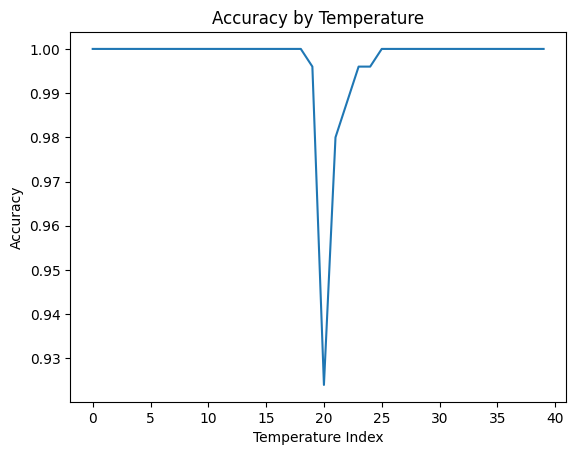

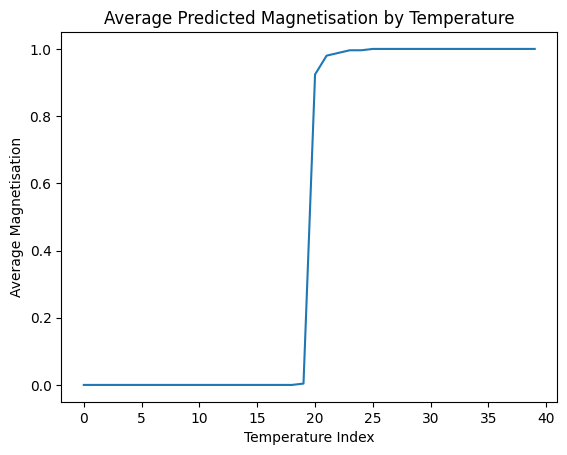

In [9]:
input_size = 30 * 30
hidden_size = 200
output_size = 2

model = IsingModelNN(input_size, hidden_size, output_size)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


N_epochs = 1000
cost_func = nn.CrossEntropyLoss()


def training_model(optimiser, learning_rate, hidden_size, wd, mom):

    model = IsingModelNN(input_size, hidden_size, output_size).to(device)
    if optimiser == torch.optim.SGD:
        optimizer = optimiser(
            model.parameters(), lr=learning_rate, weight_decay=wd, momentum=mom
        )
    if optimiser == torch.optim.Adam:
        optimizer = optimiser(model.parameters(), lr=learning_rate, weight_decay=wd)

    epoch_list = []
    cost_training = []
    cost_val = []
    acc_training = []
    acc_val = []

    for epoch in range(N_epochs):
        model.train()
        for X, y, T in train_loader:
            X, y, T = X.to(device), y.to(device), T.to(device)
            optimizer.zero_grad()
            pred = model(X, T)
            train_cost = cost_func(pred, y)
            train_cost.backward()
            optimizer.step()

        if epoch % 50 == 0:
            model.eval()
            with torch.no_grad():
                val_output = model(x_val.to(device), T_val.to(device))
                val_cost = cost_func(val_output, y_val.to(device))

                train_output = model(x_train.to(device), T_train.to(device))
                train_predicted_class = torch.argmax(train_output.detach(), axis=1)
                val_predicted_class = torch.argmax(val_output.detach(), axis=1)
                train_accuracy = torch.mean(
                    (train_predicted_class == y_train.to(device)).float()
                )
                val_accuracy = torch.mean(
                    (val_predicted_class == y_val.to(device)).float()
                )

                epoch_list.append(epoch)
                cost_training.append(train_cost.detach().cpu().numpy())
                cost_val.append(val_cost.detach().cpu().numpy())
                acc_training.append(train_accuracy.cpu().numpy())
                acc_val.append(val_accuracy.cpu().numpy())

    print(
        "Final Training cost %f\nFinal Training accuracy %f\nFinal Validation cost %f\nFinal Validation accuracy %f\n"
        % (train_cost, train_accuracy, val_cost, val_accuracy)
    )
    return model


# Train the model
best_model = training_model(torch.optim.Adam, 0.001, 100, 0.001, 0)

# Save the model
torch.save(best_model.state_dict(), "best_model.pth")

# Load the best model for evaluation
best_model.load_state_dict(torch.load("best_model.pth"))


# Evaluate the model on the test data
def evaluate(dataloader, model, loss_fn):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for X, y, T in dataloader:
            X, y, T = X.to(device), y.to(device), T.to(device)
            pred = model(X, T)
            total_loss += loss_fn(pred, y).item()
            total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    num_samples = len(dataloader.dataset)
    avg_accuracy = 100 * total_correct / num_samples
    avg_loss = total_loss / len(dataloader)
    return avg_accuracy, avg_loss


test_acc, test_loss = evaluate(test_loader, best_model, nn.CrossEntropyLoss())
print(f"Test Accuracy: {test_acc:.1f}%, Test Loss: {test_loss:.4f}")

# Additional Evaluation for Temperatures
x_L30 = np.loadtxt("x_L30.txt")
y_L30 = np.loadtxt("y_L30.txt", dtype=int)
T_L30 = np.loadtxt("T_L30.txt")

accuracies_T = np.zeros(40)
average_m = np.zeros(40)

for i in range(40):
    x_data = x_L30[i * 250 : (i + 1) * 250]
    y_data = y_L30[i * 250 : (i + 1) * 250]

    x_data = torch.tensor(x_data, dtype=torch.float32).to(device)
    y_data_onehot = np.zeros((y_data.size, output_size))
    y_data_onehot[np.arange(y_data.size), y_data] = 1
    y_data_onehot = torch.tensor(y_data_onehot, dtype=torch.float32).to(device)

    data_output = best_model(
        x_data,
        torch.tensor(T_L30[i * 250 : (i + 1) * 250], dtype=torch.float32).to(device),
    )
    data_predicted_class = torch.argmax(data_output.detach(), axis=1)
    accuracies_T[i] = torch.mean(
        (
            data_predicted_class == torch.tensor(y_data, dtype=torch.long).to(device)
        ).float()
    ).item()
    average_m[i] = torch.mean(data_predicted_class.float()).item()

plt.plot(accuracies_T)
plt.title("Accuracy by Temperature")
plt.xlabel("Temperature Index")
plt.ylabel("Accuracy")
plt.show()

plt.plot(average_m)
plt.title("Average Predicted Magnetisation by Temperature")
plt.xlabel("Temperature Index")
plt.ylabel("Average Magnetisation")
plt.show()

Seems like the plots align with the paper. As we approach the critical temperature T_c/J =~ 2.269, the model's accuracy in predicting the phase decreases, reflecting proximity to the decision boundary between the ferromagnetic and paramagnetic phases. But if we need to classify the manetizaiton farther from the critical point, we can do it with very high accuracy. 